# Identificacion de duplicados

&nbsp;  
Se describe el procedimiento para identificar marcadores con baja reproducibilidad que deben ser descartados de los análisis antes de realizar la identificación de duplicados y verificación de identidad en la colección total.

## 1. Muestras Controles

La siguiente matriz de datos contiene los genotipos SilicoDArT de 232 accesiones cuyo ADN fue enviado más de una vez, por lo que cada accesion cuenta con dos columnas de muestras (ej: sampl_1, sampl_1_rep). 59,374 filas que corresonden a cada marcador identificado por un código único.

In [1]:
controles <- readRDS("data/SilicoDArT_comparacion_controles.Rds")

In [2]:
head(controles)

,sampl_1,sampl_1_rep,sampl_2,sampl_2_rep,sampl_3,sampl_3_rep,sampl_4,sampl_4_rep,sampl_5,sampl_5_rep,⋯,sampl_228,sampl_228_rep,sampl_229,sampl_229_rep,sampl_230,sampl_230_rep,sampl_231,sampl_231_rep,sampl_232,sampl_232_rep
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
7566878,0,0,0,0,0,0,1,1,0,0,⋯,1,1,0,0,1,1,1,1,1,1
7535164,0,0,0,0,1,1,1,1,0,0,⋯,1,1,1,1,0,0,1,1,1,1
7540625,1,1,1,1,1,1,1,1,0,0,⋯,0,0,0,0,1,1,0,0,0,0
7544349,0,0,1,1,1,1,0,0,0,0,⋯,1,1,1,1,1,1,1,1,1,1
7618728,1,1,1,1,0,0,1,1,0,0,⋯,0,0,1,1,0,0,0,0,0,0
7569647,0,0,0,0,0,0,0,0,0,0,⋯,1,1,0,0,1,1,NA,1,NA,1


&nbsp;  
## 2. Calculo de reproducibilidad

&nbsp;
El siguiente script contiene la funcion que contabiliza las coincidencias y discrepancias para todos los pares de columnas. Trabaja con los datos de una sola fila (i), la cual debe ser indicada.

In [3]:
longOperationByRows <- function(Data, i){
  Re <- c()
  ## number of columns
  n <- dim(Data)[2]
  ## number of pair comparisons
  nc <- n/2
  ## Matchs count
  Mf <- 0
  ## Unmatchs count
  UMf <- 0

  for(j in 0:(nc-1))
  {
    tt <- table(ifelse(as.vector(Data[i,(j* 2 + 1)]) == as.vector(Data[i, (j* 2 + 2)]),1,0), useNA = "always")
    Matches <- tt[names(tt) =='1'][[1]]
    if(!is.na(Matches))
      M <- Matches
    else
      M <- 0
    Unmatches <- tt[names(tt) =='0'][[1]]
    if(!is.na(Unmatches))
      UM <- Unmatches
    else
      UM <- 0
    
    Mf <- Mf + M #Final matches
    UMf <- UMf + UM # Final unmatches
  }
  
    ###first method
  Re <- cbind(Mf, UMf)
  return(Re)
}

&nbsp;
&nbsp;
Utilizando la funcion anteirormente descrita, la siguiente funcion contabiliza las coincidencias y discrepancias de todo un set de datos y en base a estos añade el valor de reproducibilidad para cada marcador (fila). El resultado se almacena como "Repr"y se genera un archivo txt con los mismos resultados.

In [4]:

Reproducibility <- function(datos){
  Re <- c()
  NAS <- c()
  
  for( i in seq_len(dim(datos)[1])){
    ReTemp <- longOperationByRows(datos,i)
    Re <- rbind(Re,ReTemp)
  }
  
  Repr <- as.data.frame(Re)
  Repr$rep <- Repr$Mf /(Repr$Mf+Repr$UMf)
  row.names(Repr) <- row.names(datos)
  write.table(Repr, "matches_and_reprod.txt", quote=F, col.names=T, row.names=T)
  return(Repr)
}

&nbsp;  
Uso en el set de datos (232 parejas - 59,374 marcadores )
La sgte operación toma aproximadamente 25 minutos....

In [5]:
Reprod <- Reproducibility(controles)

In [6]:
head(Reprod)

,Mf,UMf,rep
,<dbl>,<dbl>,<dbl>
7566878,218,4,0.9819820
7535164,204,1,0.9951220
7540625,209,2,0.9905213
7544349,210,9,0.9589041
7618728,224,8,0.9655172
7569647,213,0,1.0000000


Esta tabla mantiene el orden original de los marcadores pero vamos a ordenarlos en forma descendente deacuerdo a la columna Reprod$rep que contiene los valores de reproducibilidad.

La siguiente tabla contiene las últimas filas luego de ordenarlas en orden descendente.

In [7]:
tail(Reprod[order(Reprod$rep, decreasing = T),])

,Mf,UMf,rep
,<dbl>,<dbl>,<dbl>
7532017,151,24,0.8628571
11821930,152,25,0.8587571
7549186,168,29,0.8527919
14312699,169,36,0.8243902
7562084,89,29,0.7542373
11826285,134,57,0.7015707


In [8]:
library(repr)  #es una coincidencia este nombre de paquete... lo estoy usando para redimensionar el gráfico

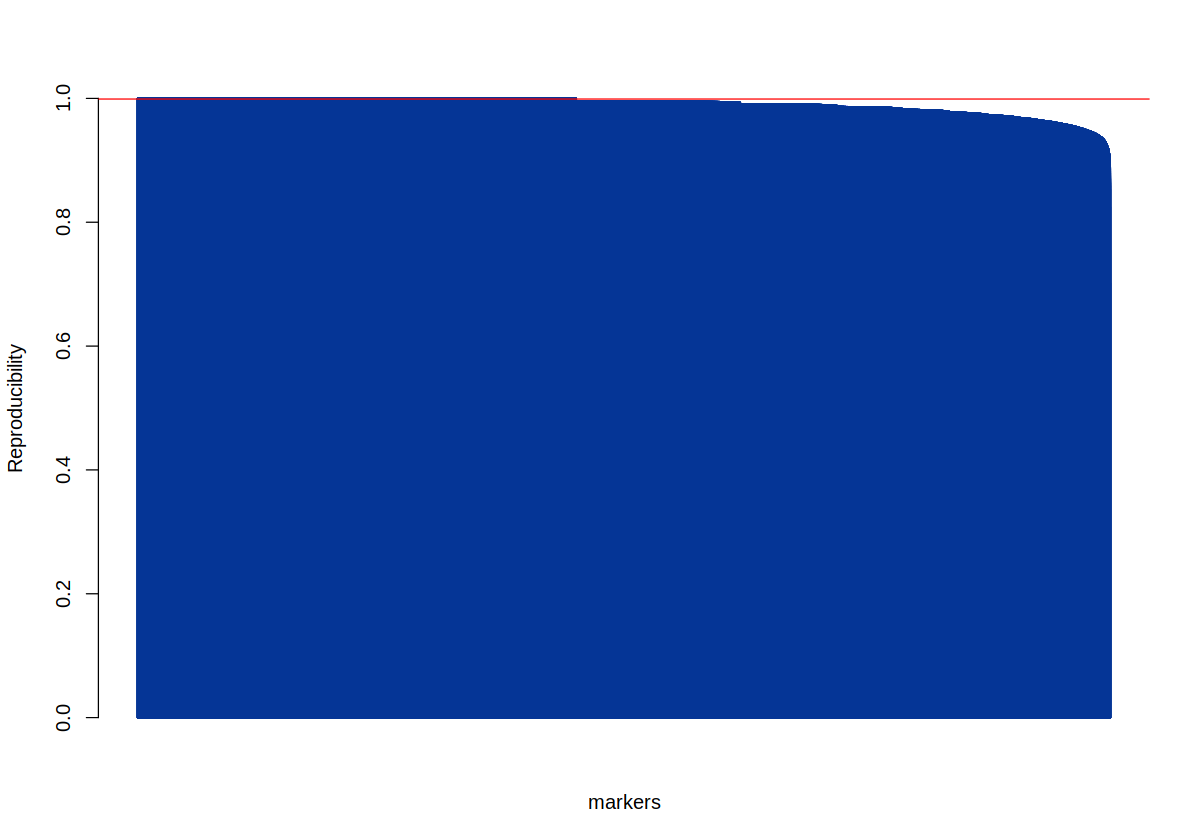

In [9]:
options(repr.plot.width=10, repr.plot.height=7)

plotear <- Reprod[order(Reprod$rep, decreasing = T),]
barplot(plotear$rep, col="#053596", border="#053596", space=0, ylim= c(0,1), xlab="markers", ylab="Reproducibility")
abline(h=1, col= 'red', lwd=2)


options(repr.plot.width=7, repr.plot.height=7)

Habiendo revisado el grafico anterior y observado los niveles de reproducibilidad, podemos buscar un valor de reproducibilidad aceptable y descartar aquellos marcadores por debajo de dicho nivel.

&nbsp;
Yo usé 0.975 como valor de reproducibilidad para determinar marcadores con “baja” reproducibilidad

In [10]:
length(which(Reprod$rep < 0.975))  #número de marcadores que entran en esta categoría de "baja" reproducibilidad

[1] 7728

## 3. Remoción de marcadores y cálculo de distancias corregidas

Ahora que tenemos identificados 7,728 marcadores que se muestran inconsistentes en la comparacion de controles, vamos a comparar el efecto de su remoción en el calculo de las distancias (Jaccard).

In [11]:
library(vegan)

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4



&nbsp;
### 3.1 Sin retirar marcadores
Primero calculamos las distancias usando el número total de marcadores (59,374)

In [12]:
# matrix.jaccard <-  vegdist(t(controles), "jaccard", na.rm = TRUE, binary=TRUE)

In [13]:
#saveRDS(matrix.jaccard, "data/matrix.jaccard.Rds")
matrix.jaccard <- readRDS("data/matrix.jaccard.Rds")

&nbsp;
### 3.2 Retirando marcadores
Primero ubicamos la lista de marcadores a retirar.

In [14]:
head(Reprod[c(which(Reprod$rep < 0.975)),])

,Mf,UMf,rep
,<dbl>,<dbl>,<dbl>
7544349,210,9,0.9589041
7618728,224,8,0.9655172
7612176,194,13,0.9371981
7625653,206,7,0.9671362
9844650,205,7,0.9669811
23645615,184,14,0.9292929


por lo que añadiendo el simbolo menos "-" se obtiene la matriz de datos con los marcadores eliminados

In [15]:
controles_ret <- controles[-c(which(Reprod$rep < 0.975)),]
dim(controles_ret)

[1] 51646   464

In [16]:
# matrix.jaccard.ret <-  vegdist(t(controles_ret), "jaccard", na.rm = TRUE, binary=TRUE)

In [17]:
#saveRDS(matrix.jaccard.ret, "data/matrix.jaccard.ret.Rds")
matrix.jaccard.ret <- readRDS("data/matrix.jaccard.ret.Rds")

&nbsp;
### 3.3 Comparación
Primero ubicamos la lista de marcadores a retirar.

In [18]:
matrix.jaccard <- as.matrix(matrix.jaccard)
matrix.jaccard.ret <- as.matrix(matrix.jaccard.ret)

&nbsp;  
Como la matriz de distancias consiste de 232 x 232 valores y solo queremos las distancias entre parejas de controles (sampl_1 vs sampl_1_rep) las extraemos de cada una de las dos matrices de distancias.

In [19]:
distancias1 <- c()
for( i in 1:(dim(matrix.jaccard)[1]/2)){
    distancias1[i] <- matrix.jaccard[2*i,2*i-1]
}

distancias2 <- c()
for( i in 1:(dim(matrix.jaccard.ret)[1]/2)){
    distancias2[i] <- matrix.jaccard.ret[2*i,2*i-1]
}

distancias1 <- cbind(distancias1,rep("all (59374)", 232))
distancias2 <- cbind(distancias2,rep("removed (51646)", 232))

In [20]:
comparacion <- as.data.frame(rbind(as.matrix(distancias1), as.matrix(distancias2)))
comparacion$V2 <- as.character(comparacion$V2)
comparacion$distancias1 <- as.numeric(comparacion$distancias1)

&nbsp;  
Finalmente se juntan las distancias extraidas y se muestran en una sola columna, la segunda columna distingue si son distancias obtenidas del total d emarcadores (59,734) o si provienen del subset de 51,646 marcadores.

In [21]:
str(comparacion)

'data.frame':	464 obs. of  2 variables:
 $ distancias1: num  0.06809 0.02346 0.02184 0.02065 0.00585 ...
 $ V2         : chr  "all (59374)" "all (59374)" "all (59374)" "all (59374)" ...


In [22]:
head(comparacion) # la columna "distancias1" contiene también los datos de "distancias2"

,distancias1,V2
,<dbl>,<chr>
1,0.068087191,all (59374)
2,0.023458336,all (59374)
3,0.021835427,all (59374)
4,0.020650355,all (59374)
5,0.005853907,all (59374)
6,0.039298959,all (59374)


&nbsp;  
Comparación de las distancias de cada pareja de controles (232 distancias) usando el set de marcadores totales y recalculando las distancias luego de retirar los marcadores con baja reproducibilidad

In [23]:
library(ggplot2)

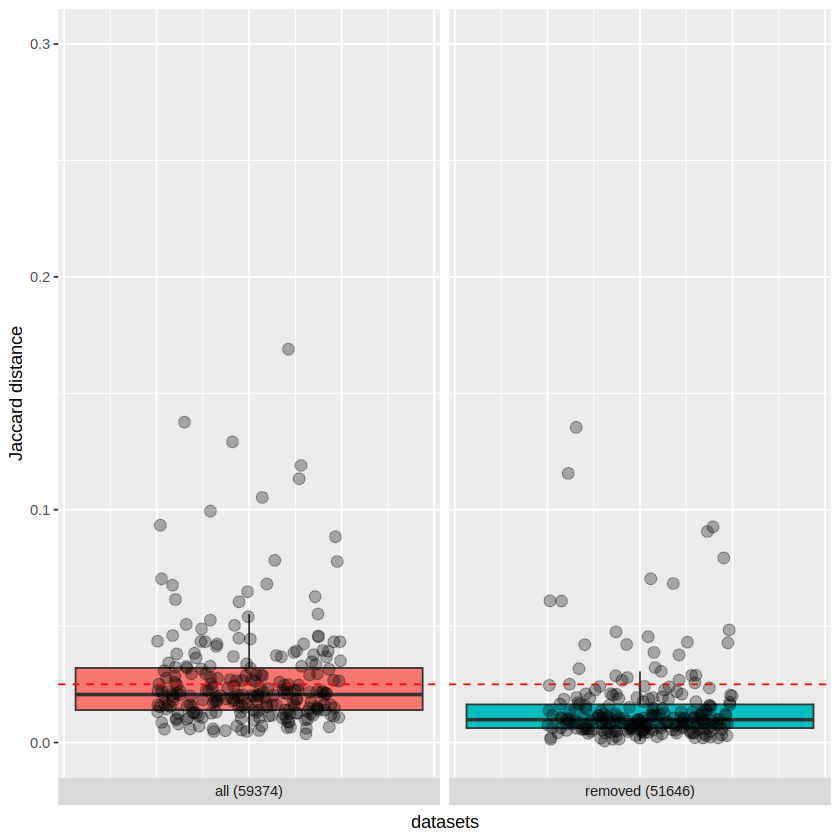

In [24]:
ggplot(comparacion, aes(fill=V2, y=distancias1, x=rep(1,464))) + 
geom_boxplot(outlier.shape = NA)+
ylim(0, 0.3)  +
facet_wrap(~V2, nrow = 1, strip.position="bottom")+ 
geom_jitter(width = 0.2, color= "black", size=3, alpha=0.3) +
theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) + 
labs(x = "datasets", y = "Jaccard distance") + 
geom_hline(yintercept=0.025, linetype="dashed", color = "red")+
theme(legend.title = element_blank(), legend.position = "none")

&nbsp;  
## 4. Estadisticas de los marcadores

Una vez identificados los marcadores con baja reproducibilidad se revisan las estadisticas previamente reportadas para cada marcador y asi explorar si los marcadores con baja reproducibilidad identificados ahora tienen alguna característica particular… o si se trata de sucesos aleatorios

In [25]:
SilicoDArT <- readRDS("data/SilicoDArT_59374markerinfo.Rds")

In [26]:
SilicoDArT[1:12,-c(2,3)]

,CloneID,CallRate,OneRatio,PIC,AvgReadDepth,StDevReadDepth,Qpmr,Reproducibility
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7556260,0.861659,0.987292,0.025093,66.31969,31.49011,2.14164,1.000000
2,7567505,0.967613,0.998247,0.003500,23.91243,12.56800,1.56819,1.000000
3,7541981,0.885410,0.989897,0.020001,126.27645,41.68338,3.45274,1.000000
4,7563470,0.931986,0.995367,0.009224,19.36576,9.34008,1.74429,1.000000
5,9844353,0.887261,0.988354,0.023021,77.00579,26.38322,3.16806,1.000000
6,11821852,0.885873,0.987291,0.025095,98.33316,34.41722,2.92505,1.000000
7,9844495,0.885256,0.989024,0.021710,178.10807,61.40620,3.12061,1.000000
8,7550113,0.877082,0.982944,0.033531,85.14892,27.84758,3.32243,1.000000
9,7560843,0.878316,0.985777,0.028041,42.89610,14.90260,3.13444,1.000000


En caso la nueva tabla tenga los marcadores en un orden diferente (que es nuestro caso)...  
...ordenamos la nueva tabla de estadísticas y la tabla con el reporte de Reproducibilidad, ambas ordenadas por la columna CloneID

In [27]:
head(SilicoDArT[order(SilicoDArT$CloneID),-c(2,3)])

,CloneID,CallRate,OneRatio,PIC,AvgReadDepth,StDevReadDepth,Qpmr,Reproducibility
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
16645,7525666,0.917181,0.745922,0.379044,33.38276,20.95586,1.57000,0.999090
36870,7525667,0.962677,0.395386,0.478112,9.06558,5.41878,1.70088,0.996315
27029,7525668,0.967767,0.388207,0.475005,18.31566,10.00690,1.78707,1.000000
50070,7525669,0.904380,0.862210,0.237608,11.62629,7.49365,1.52692,0.989642
30037,7525670,0.954503,0.603813,0.478446,14.48699,9.68897,1.45310,0.989796
41707,7525671,0.966379,0.432652,0.490929,11.38288,7.34105,1.50387,0.986498


In [28]:
head(Reprod[order(as.numeric(row.names(Reprod))),])

,Mf,UMf,rep
,<dbl>,<dbl>,<dbl>
7525666,206,0,1.0000000
7525667,209,1,0.9952381
7525668,215,0,1.0000000
7525669,181,4,0.9783784
7525670,209,0,1.0000000
7525671,214,2,0.9907407


Para que de esta forma podamos agrear el nuevo cálculo de reproducibilidad a la tabla de estadisticas por marcador

In [29]:
SilicoDArTv0 <- data.frame(SilicoDArT[order(SilicoDArT$CloneID),-c(2,3)], NvaReprod = Reprod[order(as.numeric(row.names(Reprod))),3])

In [30]:
head(SilicoDArTv0) #los rownames seguiran indicando la posicion inicial del archivo "SilicoDArT

,CloneID,CallRate,OneRatio,PIC,AvgReadDepth,StDevReadDepth,Qpmr,Reproducibility,NvaReprod
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
16645,7525666,0.917181,0.745922,0.379044,33.38276,20.95586,1.57000,0.999090,1.0000000
36870,7525667,0.962677,0.395386,0.478112,9.06558,5.41878,1.70088,0.996315,0.9952381
27029,7525668,0.967767,0.388207,0.475005,18.31566,10.00690,1.78707,1.000000,1.0000000
50070,7525669,0.904380,0.862210,0.237608,11.62629,7.49365,1.52692,0.989642,0.9783784
30037,7525670,0.954503,0.603813,0.478446,14.48699,9.68897,1.45310,0.989796,1.0000000
41707,7525671,0.966379,0.432652,0.490929,11.38288,7.34105,1.50387,0.986498,0.9907407


Estos son los marcadores retirados

In [31]:
head(subset(SilicoDArTv0, NvaReprod < 0.975))

,CloneID,CallRate,OneRatio,PIC,AvgReadDepth,StDevReadDepth,Qpmr,Reproducibility,NvaReprod
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
58292,7525678,0.952190,0.567055,0.491007,12.12001,8.06611,1.50072,0.970254,0.9463415
55130,7525713,0.877545,0.913005,0.158853,11.07320,6.72976,1.64363,0.993256,0.9655172
56834,7525720,0.897131,0.823449,0.290762,12.70956,8.00899,1.56080,0.991908,0.9580838
52294,7525749,0.920574,0.757916,0.366959,10.78995,7.34860,1.48646,0.986085,0.9736842
54530,7525763,0.890654,0.840000,0.268800,11.11028,7.02135,1.60991,0.981946,0.9679144
56018,7525785,0.951110,0.524404,0.498809,7.20827,5.00173,1.47610,0.974743,0.9622642


&nbsp;  
&nbsp;  
Finalmente vamos a graficar distintos pares de columnas, diferenciando los marcadores con buena y baja reproducibilidad para observar si esta baja reproducibilidad obedece a un patron aleatorio o si están relacionados a alguna caracteristica específica.

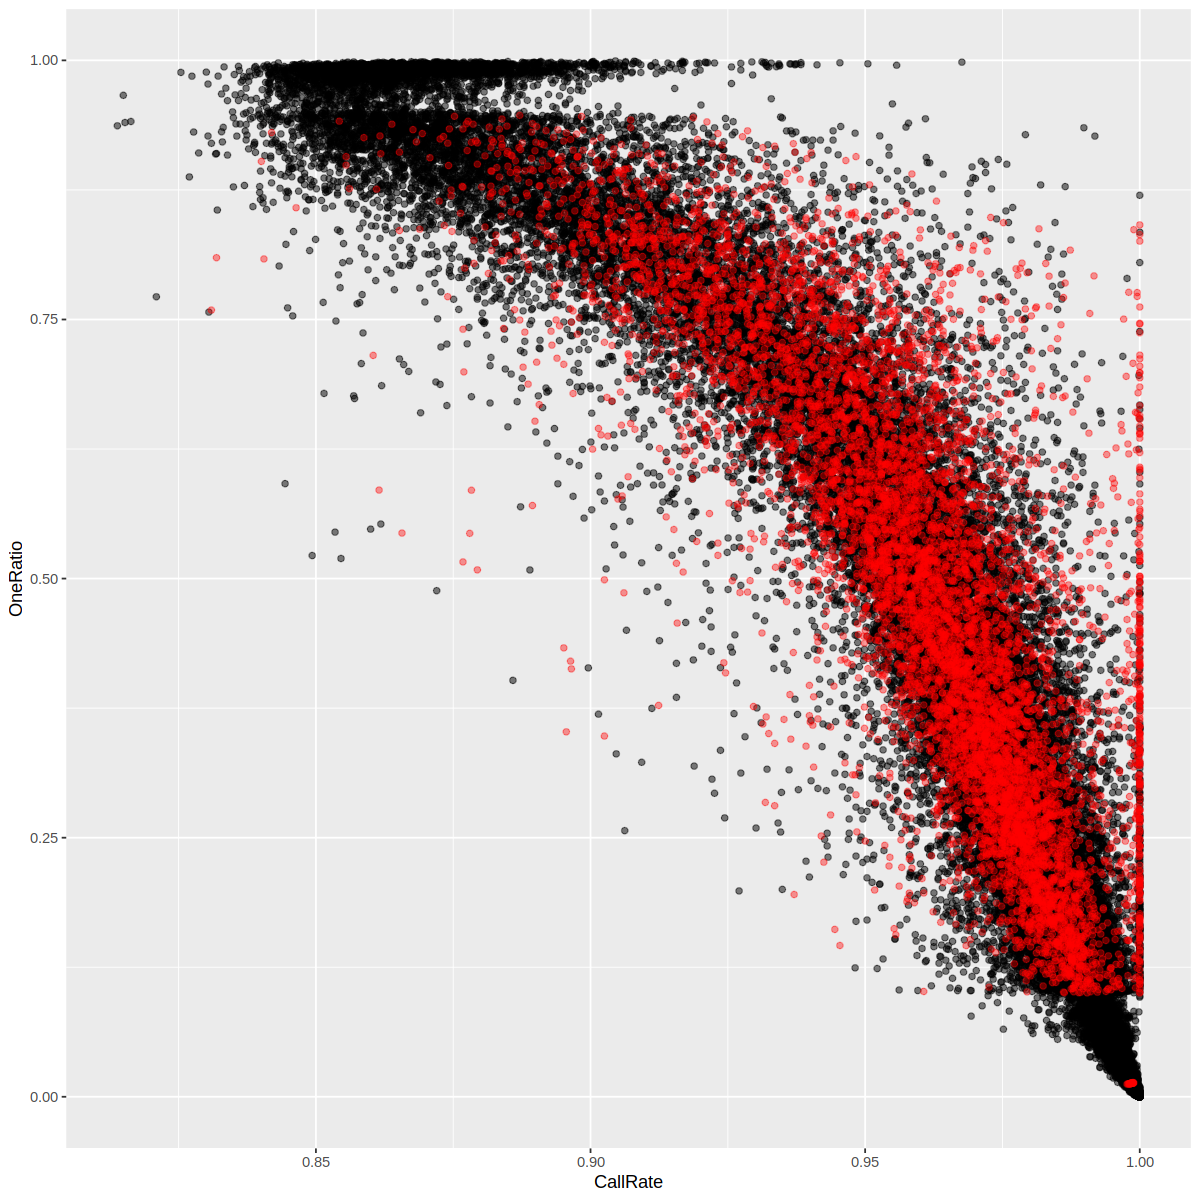

In [32]:
options(repr.plot.width=10, repr.plot.height=10)

ggplot(SilicoDArTv0, aes(y=OneRatio, x=CallRate)) +
geom_point(data= subset(SilicoDArTv0, NvaReprod >= 0.975), alpha=0.5)+
geom_point(data= subset(SilicoDArTv0, NvaReprod < 0.975), color="#ff0000", alpha=0.4)

Warning message:
“Removed 348 rows containing missing values (`geom_point()`).”


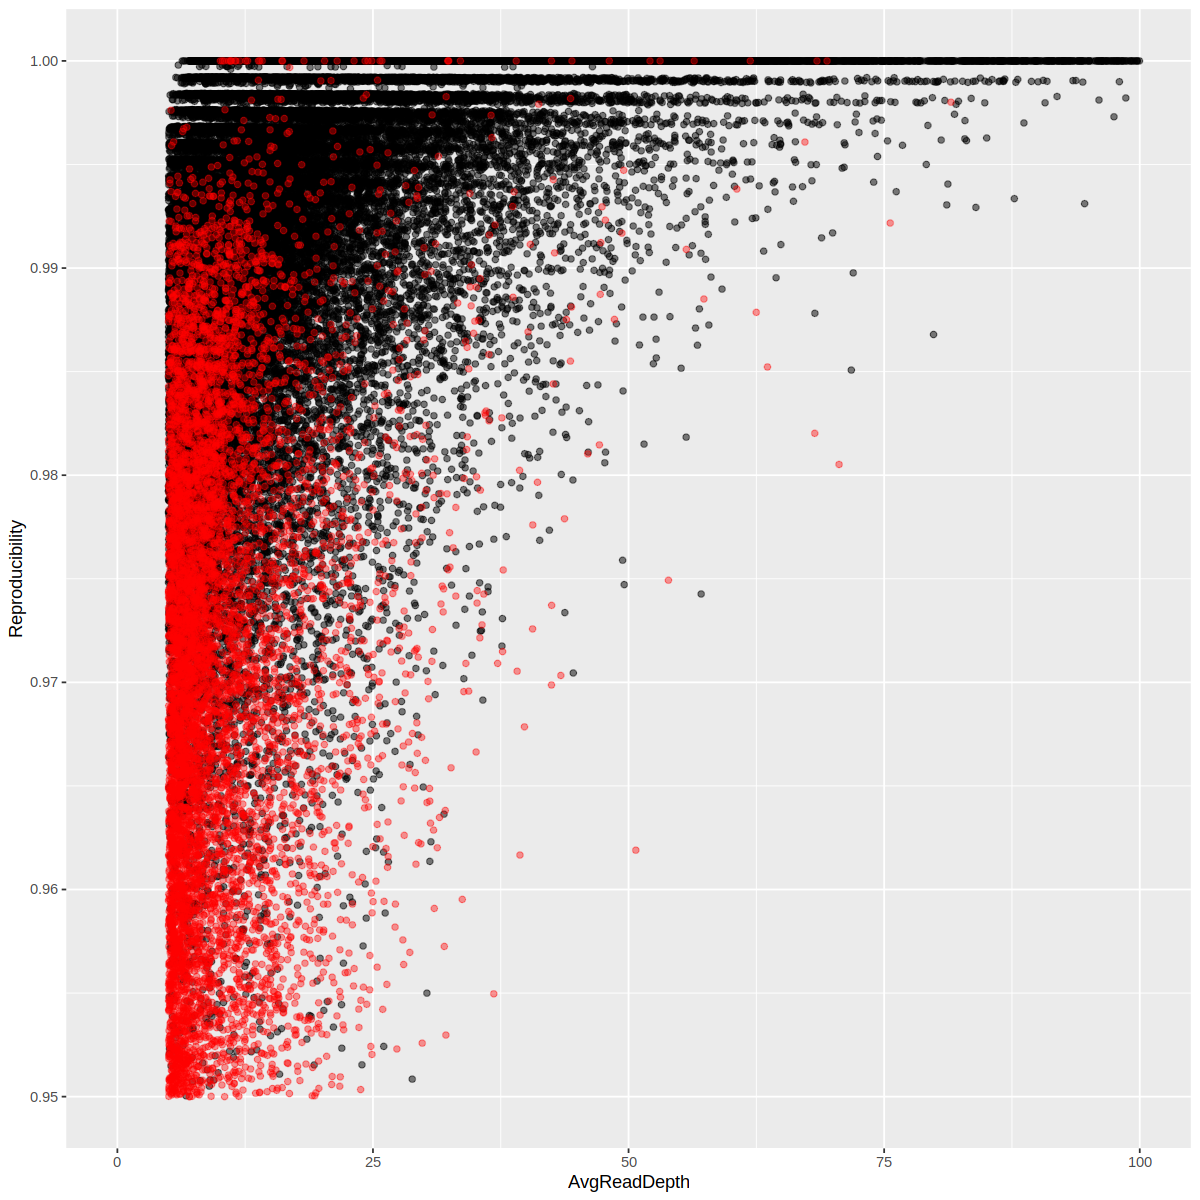

In [33]:
options(repr.plot.width=10, repr.plot.height=10)

ggplot(SilicoDArTv0, aes(y=Reproducibility, x=AvgReadDepth)) +
geom_point(data= subset(SilicoDArTv0, NvaReprod >= 0.975), alpha=0.5)+
geom_point(data= subset(SilicoDArTv0, NvaReprod < 0.975), color="#ff0000", alpha=0.4)+
xlim(0,100)

Warning message:
“Removed 354 rows containing missing values (`geom_point()`).”


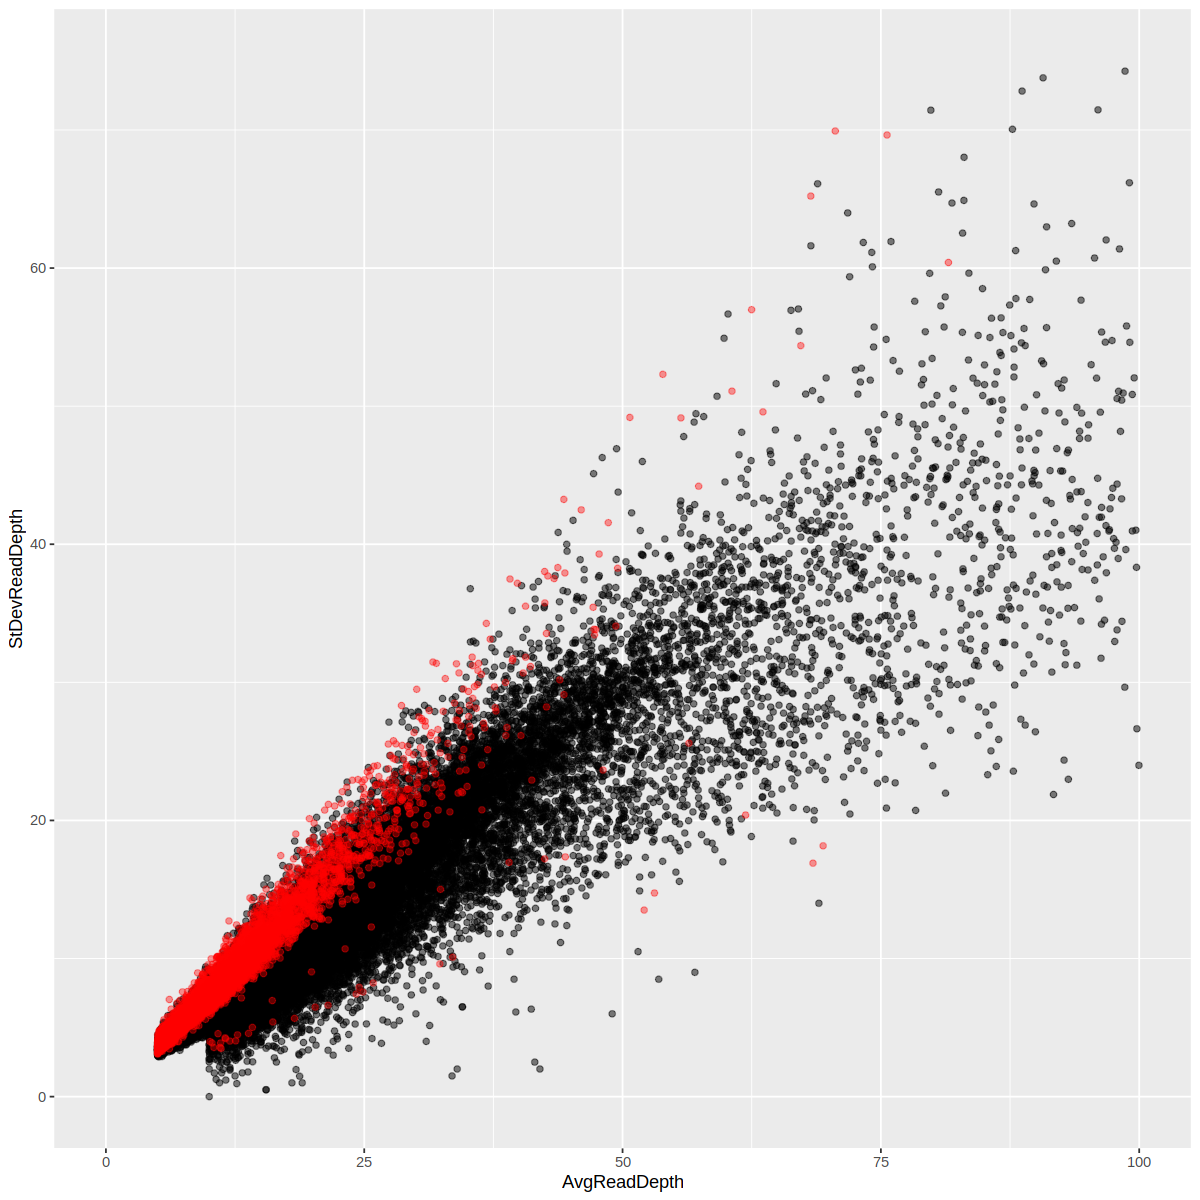

In [34]:
options(repr.plot.width=10, repr.plot.height=10)

ggplot(SilicoDArTv0, aes(y=StDevReadDepth , x=AvgReadDepth)) +
geom_point(data= subset(SilicoDArTv0, NvaReprod >= 0.975), alpha=0.5)+
geom_point(data= subset(SilicoDArTv0, NvaReprod < 0.975), color="#ff0000", alpha=0.4)+
xlim(0,100)+ylim(0,75)

Este último gráfico si permite describir que los marcadores con baja reproducibilidad están caracterizados por tener un vajo valor de AvgReadDepth (valor promedio de la profundidad de secuenciamiento) y que además presentan una desviación estándar relativamente mayor 

&nbsp;  
Este gráfico no quiere decir que todos los marcadores que se encuentren en esta área tengan un bajo indice de reproducibilidad, lo que indica es que en ésta área existe la probabilidad de encontrar dichos marcadores. Por lo que retirar todos los marcadores de esa área significaría un costo muy elevado de perdida de información. Esto refuerza la importancia de la deteccion exclusiva de los marcadores con baja reproducibilidad por el método inicialmente descrito para excluir únicamente aquellos marcadores que mostraron dicho comportamiento.